In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
class sklearn.ensemble.RandomForestClassifier
    n_estimators — число деревьев в "лесу" (по дефолту – 10)
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
    criterion — критерий "gini" (можно выбрать "entropy")
    class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
)

SyntaxError: invalid syntax (<ipython-input-2-563c35d6c5ce>, line 1)

Параметры, на которые стоит обратить внимание:
- n_estimators — число деревьев в "лесу"
- criterion — критерий для разбиения выборки в вершине
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева

In [3]:
! ls data

titanic.csv


In [4]:
train_df = pd.read_csv("data/titanic.csv")
train_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
1,1249,3,"Lockyer, Mr. Edward",male,NaN,0,0,1222,7.8792,NaN,S,0
2,1240,2,"Giles, Mr. Ralph",male,24.0,0,0,248726,13.5000,NaN,S,0
3,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,1
4,1105,2,"Howard, Mrs. Benjamin (Ellen Truelove Arman)",female,60.0,1,0,24065,26.0000,NaN,S,0


## Задание для всех

1. Взять ваш train dataset из последнего соревнования
2. Обучить дефолтный RandomForestClassifier
3. Построить learning curve - зависимость accuracy на CV от min_samples_leaf
4. min_samples_leaf - range(1, 11)



In [5]:
train_df["Title"] = train_df.Name.apply(lambda x: x.split(" ")[1].replace(".", ""))

title_stat = train_df.groupby("Title").Name.agg(["count"])

title_stat["is_rare"] = title_stat["count"] < 10
titles = title_stat[~title_stat.is_rare].index.values

train_df.Title = train_df.Title.apply(lambda x: x if x in titles else "rare_title")

train_df["Children"] = train_df.Age.apply(lambda x: 1 if x < 18 else 0)
train_df["Mother"] = train_df.apply(lambda x: 1 if x.Sex == "female" and x.Age > 18 and x.Parch > 0 else 0, axis=1)
train_df["Family_size"] = train_df.SibSp + train_df.Parch + 1

train_df["Deck"] = train_df.Cabin.astype("str").apply(lambda x: x[0] if x != "nan" else "no_deck")

In [6]:
def preprocessing(df):
    unnecessary_cols = ["Name", "Ticket", "SibSp", "Parch", "Cabin"]

    df = df.drop(unnecessary_cols, axis=1)
    df.Age = df.Age.fillna(0).astype("int8")
    df.Fare = df.Fare.fillna(0)
    df.Embarked = df.Embarked.fillna("no_info")
    
    return df

train_df = preprocessing(train_df)
train_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Title,Children,Mother,Family_size,Deck
0,888,1,female,19,30.0000,S,1,Miss,0,0,1,B
1,1249,3,male,0,7.8792,S,0,Mr,0,0,1,no_deck
2,1240,2,male,24,13.5000,S,0,Mr,0,0,1,no_deck
3,221,3,male,16,8.0500,S,1,Mr,1,0,1,no_deck
4,1105,2,female,60,26.0000,S,0,Mrs,0,0,2,no_deck


In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoding_cols = ["Sex", "Embarked", "Title", "Deck"]

full_df = train_df

for col in encoding_cols:
    full_df[col] = encoder.fit_transform(full_df[col])
    
train_df = full_df[full_df.Survived.notnull()]
train_df.Survived = train_df.Survived.astype("int8")

100%|██████████| 100/100 [00:07<00:00, 14.24it/s]


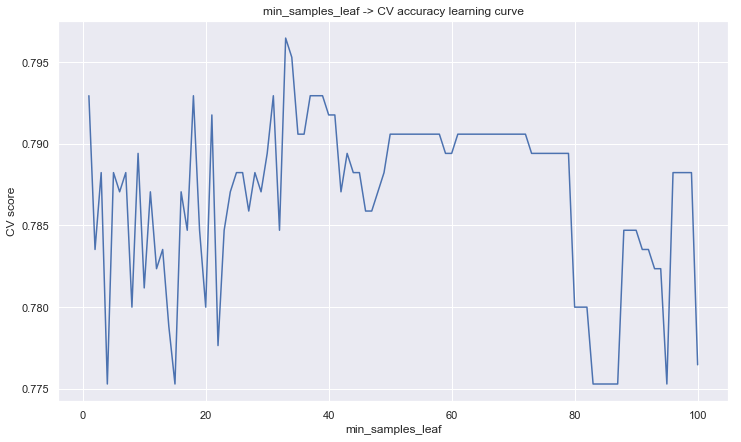

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

X = train_df.drop(["Survived", "PassengerId"], axis=1)
y = train_df.Survived

folds = StratifiedKFold(5)

param_grid = range(1, 101, 1)
scores = []

for param in tqdm(param_grid):
    model = RandomForestClassifier(min_samples_leaf=param, random_state=42)
    score = np.mean(cross_val_score(model, X, y, cv=folds, scoring="accuracy"))
    scores.append(score)
    
plt.figure(figsize=(12,7))
plt.title("min_samples_leaf -> CV accuracy learning curve")
plt.plot(param_grid, scores)
plt.xlabel("min_samples_leaf")
plt.ylabel("CV score")
plt.show()

100%|██████████| 9/9 [00:03<00:00,  2.17it/s]


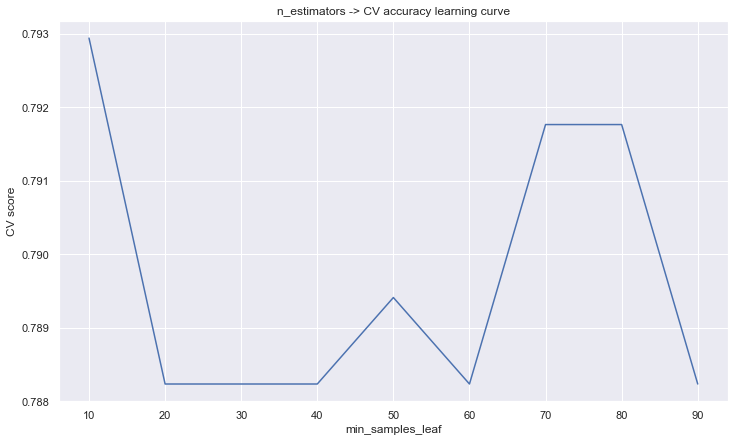

In [9]:
param_grid = range(10, 100, 10)
scores = []

for param in tqdm(param_grid):
    model = RandomForestClassifier(
        n_estimators=param,
        min_samples_leaf=1,
        random_state=42
    )
    score = np.mean(cross_val_score(model, X, y, cv=folds, scoring="accuracy"))
    scores.append(score)
    
plt.figure(figsize=(12,7))
plt.title("n_estimators -> CV accuracy learning curve")
plt.plot(param_grid, scores)
plt.xlabel("min_samples_leaf")
plt.ylabel("CV score")
plt.show()

100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


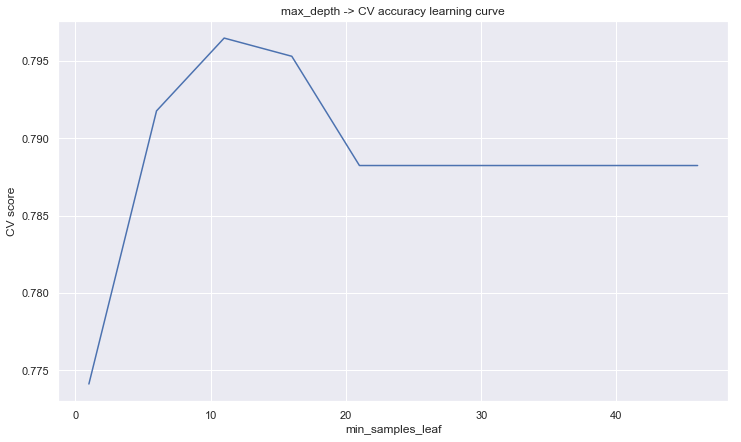

In [14]:
param_grid = range(1, 51, 5)
scores = []

for param in tqdm(param_grid):
    model = RandomForestClassifier(
        n_estimators=30,
        min_samples_leaf=1,
        max_depth=param,
        random_state=42
    )
    score = np.mean(cross_val_score(model, X, y, cv=folds, scoring="accuracy"))
    scores.append(score)
    
plt.figure(figsize=(12,7))
plt.title("max_depth -> CV accuracy learning curve")
plt.plot(param_grid, scores)
plt.xlabel("min_samples_leaf")
plt.ylabel("CV score")
plt.show()

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": range(1, 101, 10),
    "min_samples_leaf": range(1, 10, 1),
}

model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy",
                    n_jobs=-1)
model.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 101, 10), 'min_samples_leaf': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [24]:
model.best_params_

{'max_depth': 31, 'min_samples_leaf': 3}

### Рефакторинг

Вместо копипаста делаем одну функцию, которая использует именованные аргументы
в Python. Применяя данный функционал, мы делаем наш код короче, чище и понятнее.

In [42]:
def evaluate_params(X, y, *args, **kwargs):
    model = RandomForestClassifier(**kwargs)
    score = np.mean(cross_val_score(model, X, y, cv=folds, scoring="accuracy"))
    
    return model, score

def sample_leaf_curve(X, y, grid):
    scores = []
    
    for param in grid:
        model, score = evaluate_params(X, y, min_samples_leaf=param)
        scores.append(score)
        
    return scores
    
leaf_grid = range(1, 11, 1)
leaf_grid_scores = sample_leaf_curve(X, y, leaf_grid)
leaf_grid_scores

[0.7788235294117647,
 0.7858823529411765,
 0.8011764705882353,
 0.7976470588235294,
 0.7929411764705883,
 0.7882352941176471,
 0.8011764705882353,
 0.7988235294117646,
 0.8035294117647058,
 0.7929411764705881]

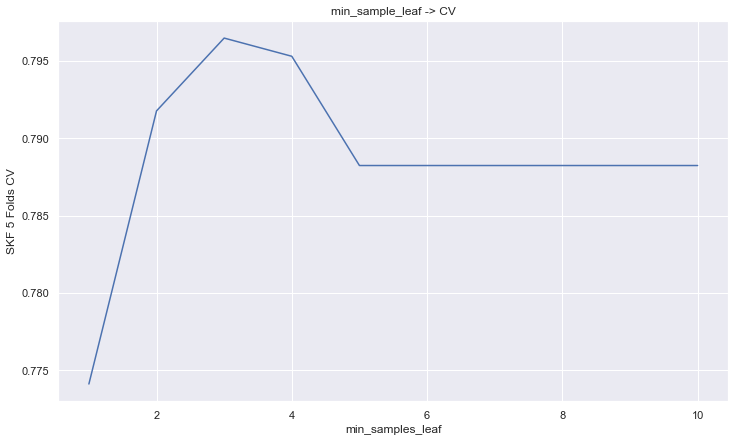

In [41]:
plt.figure(figsize=(12,7))
plt.title("min_sample_leaf -> CV")
plt.plot(leaf_grid, scores, label="CV score")
plt.xlabel("min_samples_leaf")
plt.ylabel("SKF 5 Folds CV")
plt.show()